# Inverted Pendulum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import linalg
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import control

In [2]:
# SETUP

# constants
mass_cart = 2
mass_pendulum = .1
L = .25
J = mass_pendulum*(L**2)
g = 9.81
linear_thesh = math.pi/9

# nonlinear dymanics equations
def x_ddot(theta, theta_dot, u):
    common_denominator = J*(mass_cart+mass_pendulum)-(mass_pendulum**2)*(L**2)*(math.cos(theta)**2)
    f_x = (J*mass_pendulum*L*math.sin(theta)*(theta_dot**2)-(mass_pendulum**2)*g*(L**2)*math.sin(theta)*math.cos(theta))/common_denominator
    b_x = J/common_denominator
    
    return f_x + b_x*u

def theta_ddot(theta, theta_dot, u):
    common_denominator = J*(mass_cart+mass_pendulum)-(mass_pendulum**2)*(L**2)*(math.cos(theta)**2)
    f_theta = (mass_cart+mass_pendulum)*(mass_pendulum*g*L*math.sin(theta)-(mass_pendulum**2)*(L**2)*math.cos(theta)*math.sin(theta)*(theta_dot**2))/common_denominator
    b_theta = -(mass_pendulum*L*math.cos(theta))/common_denominator
    
    return f_theta + b_theta*u

In [4]:
# LINEAR X-BOUNDING CONTROLLER GAIN

# linear dynamics of cart w/o pendulum
A = np.array([[0, 1],
              [0, 0]])
B = np.array([[0],
              [1/mass_cart]])

# pole placement
p = np.array([-1, -2])

# feedback gains
K_linear_bound = control.place(A, B, p)
print(K_linear_bound)

[[4. 6.]]


/Users/willmartin/miniforge3/envs/general/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


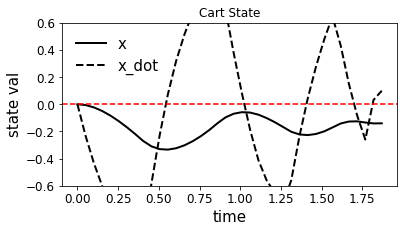

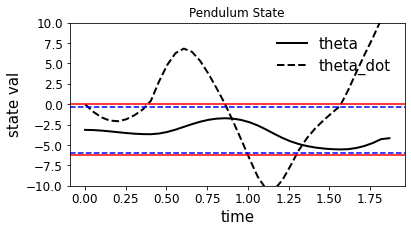

In [6]:
# NONLINEAR CONTROLLER + LINEAR X-BOUNDING CONTROLLER

def f_nonlinear(state_vector, t):
    # states
    x, x_dot, theta, theta_dot = state_vector
    
    E_0 = 0
    E = (1/2)*J*(theta_dot**2)+mass_pendulum*g*L*(math.cos(theta)-1)
    omega = mass_pendulum*L*theta_dot*math.cos(theta)*(E_0-E)
    
    # controller
    eta = 5.4 # > (abs(f_x)/abs(b_x))
    u = -eta*np.sign(omega) - K_linear_bound@[x, x_dot]
    
    return [x_dot, x_ddot(theta, theta_dot, u), theta_dot, theta_ddot(theta, theta_dot, u)]

# initial conditions
t0 = 0.0
x0 = [0, 0, -math.pi, 0]

# solve IVP
t1 = t0 + 5
n = 100
t = np.linspace(t0, t1, n)
sol = odeint(f_nonlinear, x0, t)

# time system enter linear region
idx_linear = np.argmax((sol[:,2] > -linear_thesh) | (sol[:,2] < -(2*math.pi)+linear_thesh))
t_linear = idx_linear * (t1-t0)/n
state_linear = sol[idx_linear]

# truncate solution
sol = sol[:idx_linear,:]
t = t[:idx_linear]

# plot cart state
plt.figure(figsize=(6,3))
plt.title("Cart State")
plt.ylim(-.6, .6)
plt.plot(t, sol[:,0], 'k-', label='x', linewidth =2)
plt.plot(t, sol[:,1], 'k--', label='x_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='--')

plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("state val", size=15)
plt.xlabel('time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# plot pendulum state
plt.figure(figsize=(6,3))
plt.title("Pendulum State")
plt.ylim(-10, 10)
plt.plot(t, sol[:,2], 'k-', label='theta', linewidth =2)
plt.plot(t, sol[:,3], 'k--', label='theta_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=-linear_thesh, color='b', linestyle='--')
plt.axhline(y=-(2*math.pi), color='r', linestyle='-')
plt.axhline(y=-(2*math.pi)+linear_thesh, color='b', linestyle='--')


plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("state val", size=15)
plt.xlabel('time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [137]:
# LINEAR CONTROLLER GAIN

A = np.array([[0,1,0,0],
              [(3*(mass_cart+mass_pendulum)*g)/(4*mass_cart*L+mass_pendulum*L),0,0,0],
              [0,0,0,1],
              [-(3*mass_pendulum*g)/(4*mass_cart+mass_pendulum),0,0,0]])
B = np.array([[0],
              [-(3)/(4*mass_cart*L+mass_pendulum*L)],
              [0],
              [(4)/(4*mass_cart+mass_pendulum)]])
Q = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,10,0],
              [0,0,0,1]])
R = np.array([1])

K_linear, _, _ = control.lqr(A, B, Q, R)
print(K_linear)

[[-56.83602134 -10.38689076  -3.16227766  -4.93567592]]


[-0.05508735 -0.42017041 -0.2909101   1.10383266]


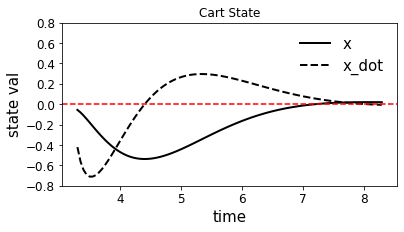

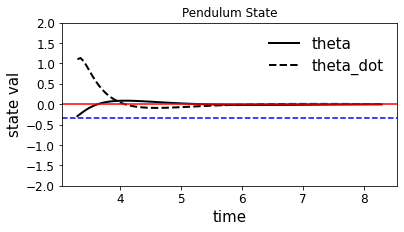

In [138]:
# LINEAR CONTROLLER

# NONLINEAR CONTROLLER + LINEAR X-BOUNDING CONTROLLER

def f_linear(state_vector, t):
    # states
    x, x_dot, theta, theta_dot = state_vector
    
    # controller
    u = -K_linear@np.array([[theta], [theta_dot], [x], [x_dot]])
    
    return [x_dot, x_ddot(theta, theta_dot, u), theta_dot, theta_ddot(theta, theta_dot, u)]

# initial conditions
t0 = t_linear
x0 = state_linear
print(x0)

# solve IVP
t1 = t0 + 5
n = 100
t = np.linspace(t0, t1, n)
sol = odeint(f_linear, x0, t)

# plot cart state
plt.figure(figsize=(6,3))
plt.title("Cart State")
plt.ylim(-.8, .8)
plt.plot(t, sol[:,0], 'k-', label='x', linewidth =2)
plt.plot(t, sol[:,1], 'k--', label='x_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='--')

plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("state val", size=15)
plt.xlabel('time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# plot pendulum state
plt.figure(figsize=(6,3))
plt.title("Pendulum State")
plt.ylim(-2, 2)
plt.plot(t, sol[:,2], 'k-', label='theta', linewidth =2)
plt.plot(t, sol[:,3], 'k--', label='theta_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=-linear_thesh, color='b', linestyle='--')
plt.axhline(y=-(2*math.pi), color='r', linestyle='-')
plt.axhline(y=-(2*math.pi)+linear_thesh, color='b', linestyle='--')


plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("state val", size=15)
plt.xlabel('time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()